In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from prod import *
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Configure Training and Test Set

In [2]:
DF = pd.read_csv('../../data_preparation/output/total_compounds.csv')
df = DF.sample(n=1000000, random_state=10)

seed_val=0
frac=0.95

all_bb1 = unique_bb(df, bb_pos='bb1')
all_bb2 = unique_bb(df, bb_pos='bb2')
all_bb3 = unique_bb(df, bb_pos='bb3')

bb1_train, bb1_test = sample_bb(all_bb1, bb_pos='bb1', frac=frac, seed=seed_val)
bb2_train, bb2_test = sample_bb(all_bb2, bb_pos='bb2', frac=frac, seed=seed_val)
bb3_train, bb3_test = sample_bb(all_bb3, bb_pos='bb3', frac=frac, seed=seed_val)

train, test = train_test_set(df, bb1_train, bb2_train, bb3_train)

bb1_train, bb1_test = update_bbs(train, bb1_train, bb1_test, 'bb1')
bb2_train, bb2_test = update_bbs(train, bb2_train, bb2_test, 'bb2')
bb3_train, bb3_test = update_bbs(train, bb3_train, bb3_test, 'bb3')

bb1_train = calc_pactive(train, bb1_train, bb_pos='bb1')
bb2_train = calc_pactive(train, bb2_train, bb_pos='bb2')
bb3_train = calc_pactive(train, bb3_train, bb_pos='bb3')

In [16]:
all_bb1

array(['CN[C@@H](c1ccccc1)C(=O)O', 'C1[C@@H](CN[C@@H]1C(=O)O)F',
       'C1C[C@H](Cn2c1nnc2C3CCNCC3)C(=O)O',
       'c1ccc(c(c1)C[C@@H](C(=O)O)N)Cl', 'c1ccc(cc1)CNCCC(=O)O',
       'C1CC(CCC1CN)C(=O)O', 'C1CCC(CC1)CC[C@H](C(=O)O)N',
       'C1CCC2C(C1)C[C@H](N2)C(=O)O',
       'c1ccc2c(c1)c(c[nH]2)C[C@@H](CC(=O)O)N', 'CCC[C@@H](C(=O)O)N',
       'c1ccc(c(c1)C[C@H](C(=O)O)N)C#N', 'NCC1CCN(CC2=CC=CS2)CC1',
       'C1CC(CCC1C(=O)O)N', 'CC1=C(CN)C=NN1C',
       'c1c(nc(s1)[C@@H]2CCNC2)C(=O)O', 'NCC1=CN2C=CC=NC2=N1',
       'C1CC1[C@@H](C(=O)O)N', 'NCC1=C(CN2C=CC=N2)C=CC=C1',
       'CC1=C(CN)C=C(F)C=C1', 'COC1=CC=C(OCCN)C=C1',
       'c1cc(cc(c1)Cl)C(C(=O)O)N', 'NCC1=CC(C2=CC=C(Cl)C=C2)=NO1',
       'c1ccc(c(c1)C[C@H](C(=O)O)N)Br', 'CCS(=O)(=O)CCN',
       'C[C@H]([C@@H](C(=O)O)N)OCc1ccccc1', 'COc1ccc(cc1)C(CC(=O)O)N',
       'c1cc(cc(c1)F)C[C@H](C(=O)O)N', 'C(C(=O)O)N', 'C=CCCN',
       'CC(C)CC(CC(=O)O)N', 'CC1=CSC(CN)=C1',
       'c1ccc(cc1)[C@@H](CC(=O)O)N', 'c1ccc(cc1)[C@H]2CCN[C@@H]2

In [3]:
bb1_ref = pd.read_csv('../../data_preparation/output/bb1_list.csv').reset_index()
bb2_ref = pd.read_csv('../../data_preparation/output/bb2_list.csv').reset_index()
bb3_ref = pd.read_csv('../../data_preparation/output/bb3_list.csv').reset_index()

In [4]:
bb1_train_ind = match(bb1_train, bb1_ref, bb_pos='bb1')
bb1_test_ind = match(bb1_test, bb1_ref, bb_pos='bb1')

bb2_train_ind = match(bb2_train, bb2_ref, bb_pos='bb2')
bb2_test_ind = match(bb2_test, bb2_ref, bb_pos='bb2')

bb3_train_ind = match(bb3_train, bb3_ref, bb_pos='bb3')
bb3_test_ind = match(bb3_test, bb3_ref, bb_pos='bb3')

### Transform similarity scores into UMAP distances

In [5]:
bb1_sim_3D = np.load('../../similarity_calculation/output/bb1_list.npy')
bb2_sim_3D = np.load('../../similarity_calculation/output/bb2_list.npy')
bb3_sim_3D = np.load('../../similarity_calculation/output/bb3_list.npy')

bb1_dist = dist_mat(bb1_sim_3D)
bb2_dist = dist_mat(bb2_sim_3D)
bb3_dist = dist_mat(bb3_sim_3D)

bb1_coords, bb1_umap = UMAP_dist(bb1_dist[np.ix_(bb1_train_ind, bb1_train_ind)], seed=seed_val)
bb2_coords, bb2_umap = UMAP_dist(bb2_dist[np.ix_(bb2_train_ind, bb2_train_ind)], seed=seed_val)
bb3_coords, bb3_umap = UMAP_dist(bb3_dist[np.ix_(bb3_train_ind, bb3_train_ind)], seed=seed_val)

,Position,top - top dist,top - rand dist
0,1,3.878902,6.394838
1,2,0.993839,8.107125
2,3,3.853472,11.161160


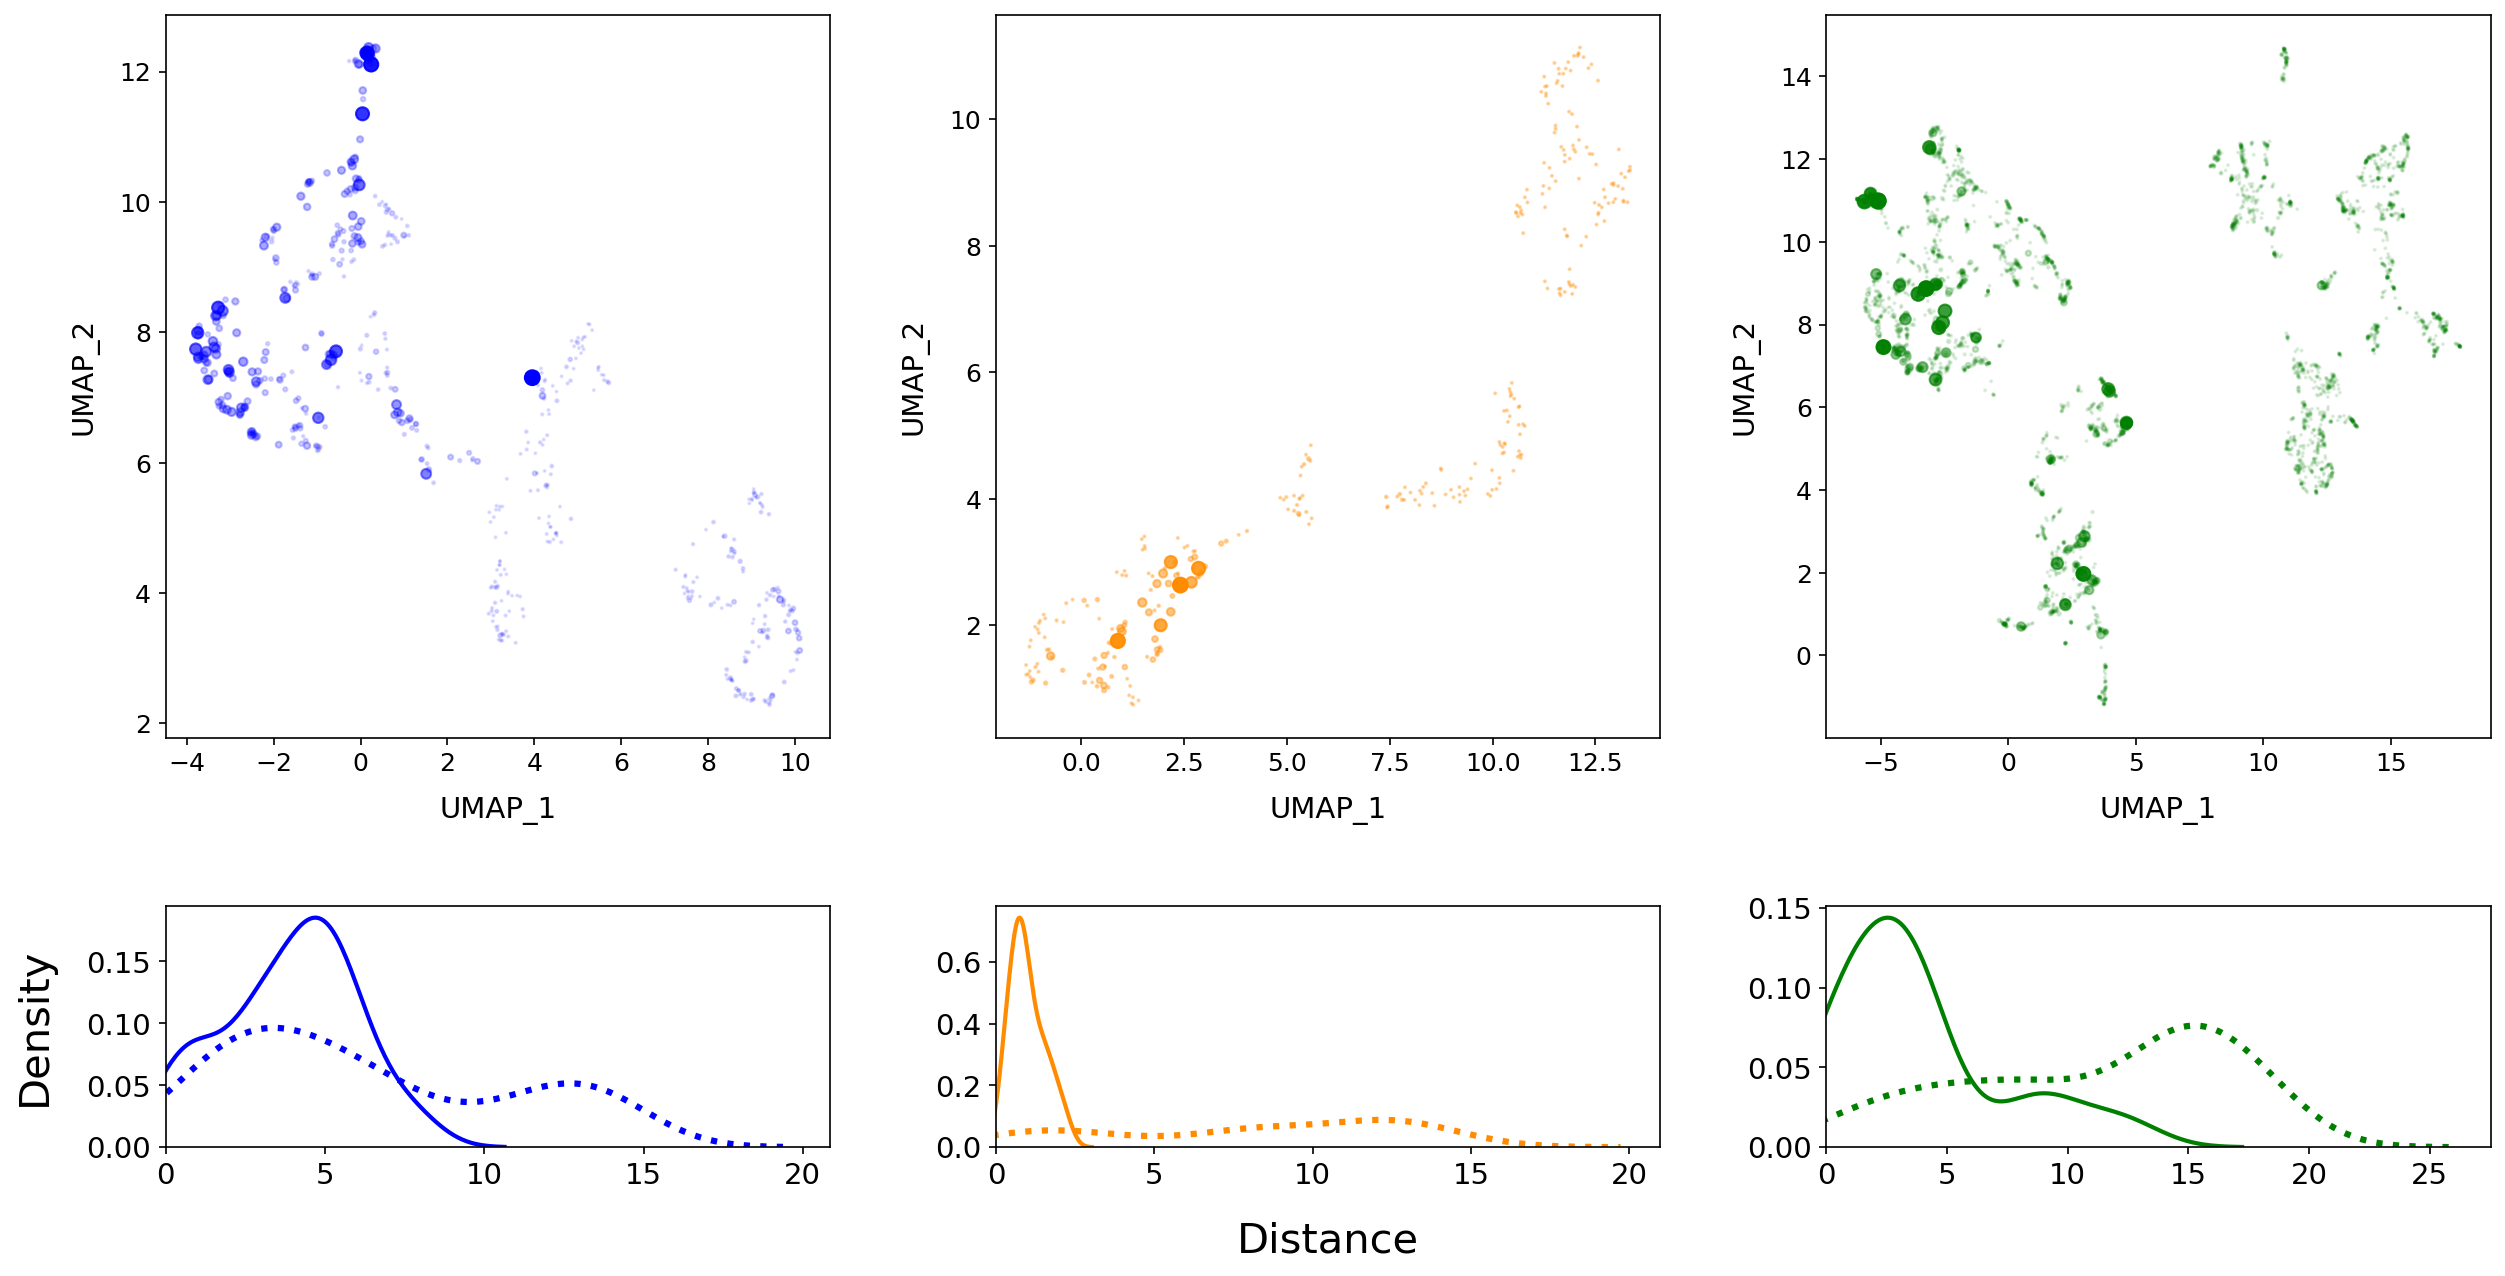

In [6]:
bb1_train, bb2_train, bb3_train = plot_umap(bb1_train, bb2_train, bb3_train, bb1_umap, bb2_umap, bb3_umap)

### Determine optimal HDBSCAN hyperparameters

In [7]:
bb1_train = assign_coords(bb1_train, bb1_coords)
bb2_train = assign_coords(bb2_train, bb2_coords)
bb3_train = assign_coords(bb3_train, bb3_coords)

opt_params_bb1 = optimal_hdbscan(bb1_train)
opt_params_bb2 = optimal_hdbscan(bb2_train)
opt_params_bb3 = optimal_hdbscan(bb3_train)

In [8]:
bb1_clusterer, bb1_cluster_labels = cluster(bb1_train, opt_params_bb1)
bb2_clusterer, bb2_cluster_labels = cluster(bb2_train, opt_params_bb2)
bb3_clusterer, bb3_cluster_labels = cluster(bb3_train, opt_params_bb3)

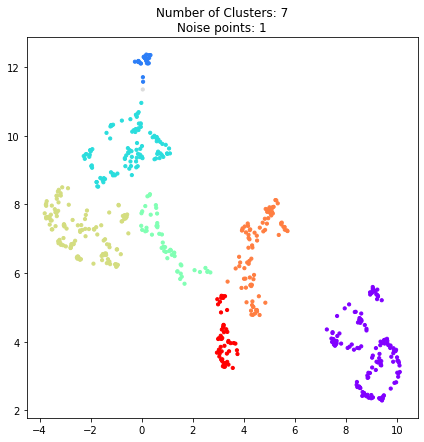

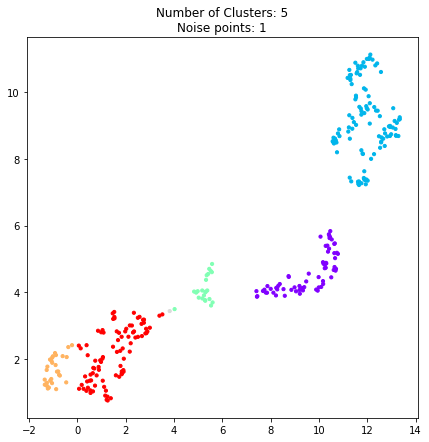

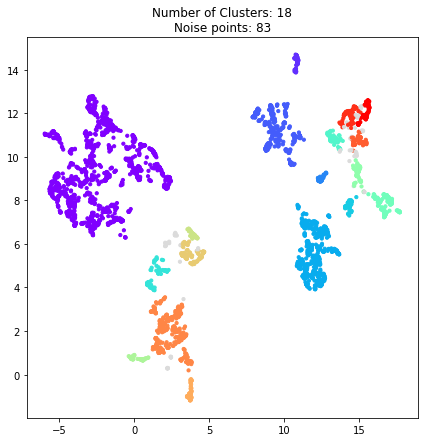

In [9]:
bb1_train = plot_hdbscan(bb1_train, opt_params_bb1, bb1_umap)
bb2_train = plot_hdbscan(bb2_train, opt_params_bb2, bb2_umap)
bb3_train = plot_hdbscan(bb3_train, opt_params_bb3, bb3_umap)

### Predict the cluster assignments for test set building blocks

In [20]:
bb1_cluster

array([ 6,  6,  4,  0,  3,  0,  0,  0,  4,  1,  4,  5,  0,  6,  0,  2,  0,
        5,  2,  4,  3,  4,  6,  6,  0,  2,  3, -1,  0,  6,  0],
      dtype=int32)

In [10]:
bb1_test_coords, bb1_cluster, bb1_prob = predict_cluster(bb1_umap, bb1_clusterer, bb1_dist, bb1_train_ind, bb1_test_ind)
bb2_test_coords, bb2_cluster, bb2_prob = predict_cluster(bb2_umap, bb2_clusterer, bb2_dist, bb2_train_ind, bb2_test_ind)
bb3_test_coords, bb3_cluster, bb3_prob = predict_cluster(bb3_umap, bb3_clusterer, bb3_dist, bb3_train_ind, bb3_test_ind)

bb1_test = assign_coords(bb1_test, bb1_test_coords)
bb2_test = assign_coords(bb2_test, bb2_test_coords)
bb3_test = assign_coords(bb3_test, bb3_test_coords)

bb1_test['Cluster'] = bb1_cluster
bb2_test['Cluster'] = bb2_cluster
bb3_test['Cluster'] = bb3_cluster

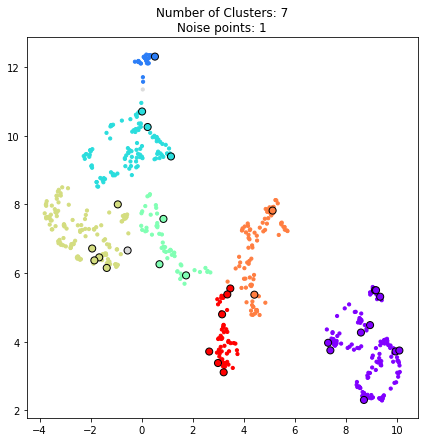

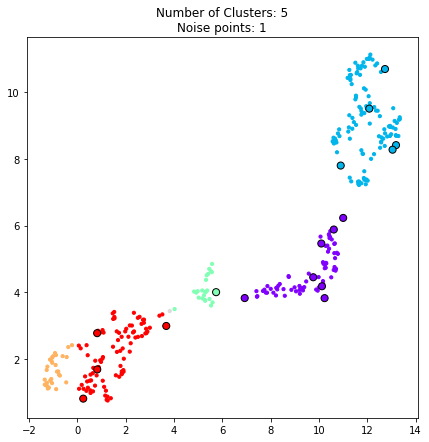

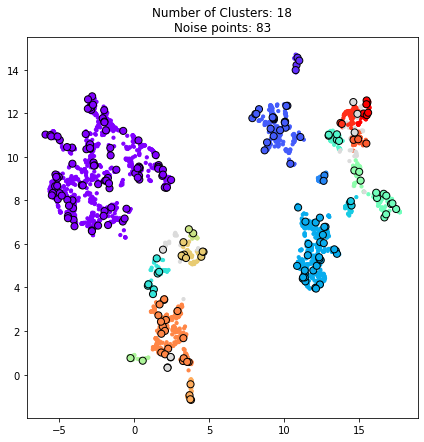

In [11]:
_ = plot_hdbscan(bb1_train, opt_params_bb1, bb1_umap, bb1_test)
_ = plot_hdbscan(bb2_train, opt_params_bb2, bb2_umap, bb2_test)
_ = plot_hdbscan(bb3_train, opt_params_bb3, bb3_umap, bb3_test)

### Estimate P(active) of test set building blocks

### Create decision tree

In [12]:
train_input = format_data_for_tree(train, bb1_train, bb2_train, bb3_train)
tree_classifier = create_tree(train_input, seed=seed_val, depth=5)

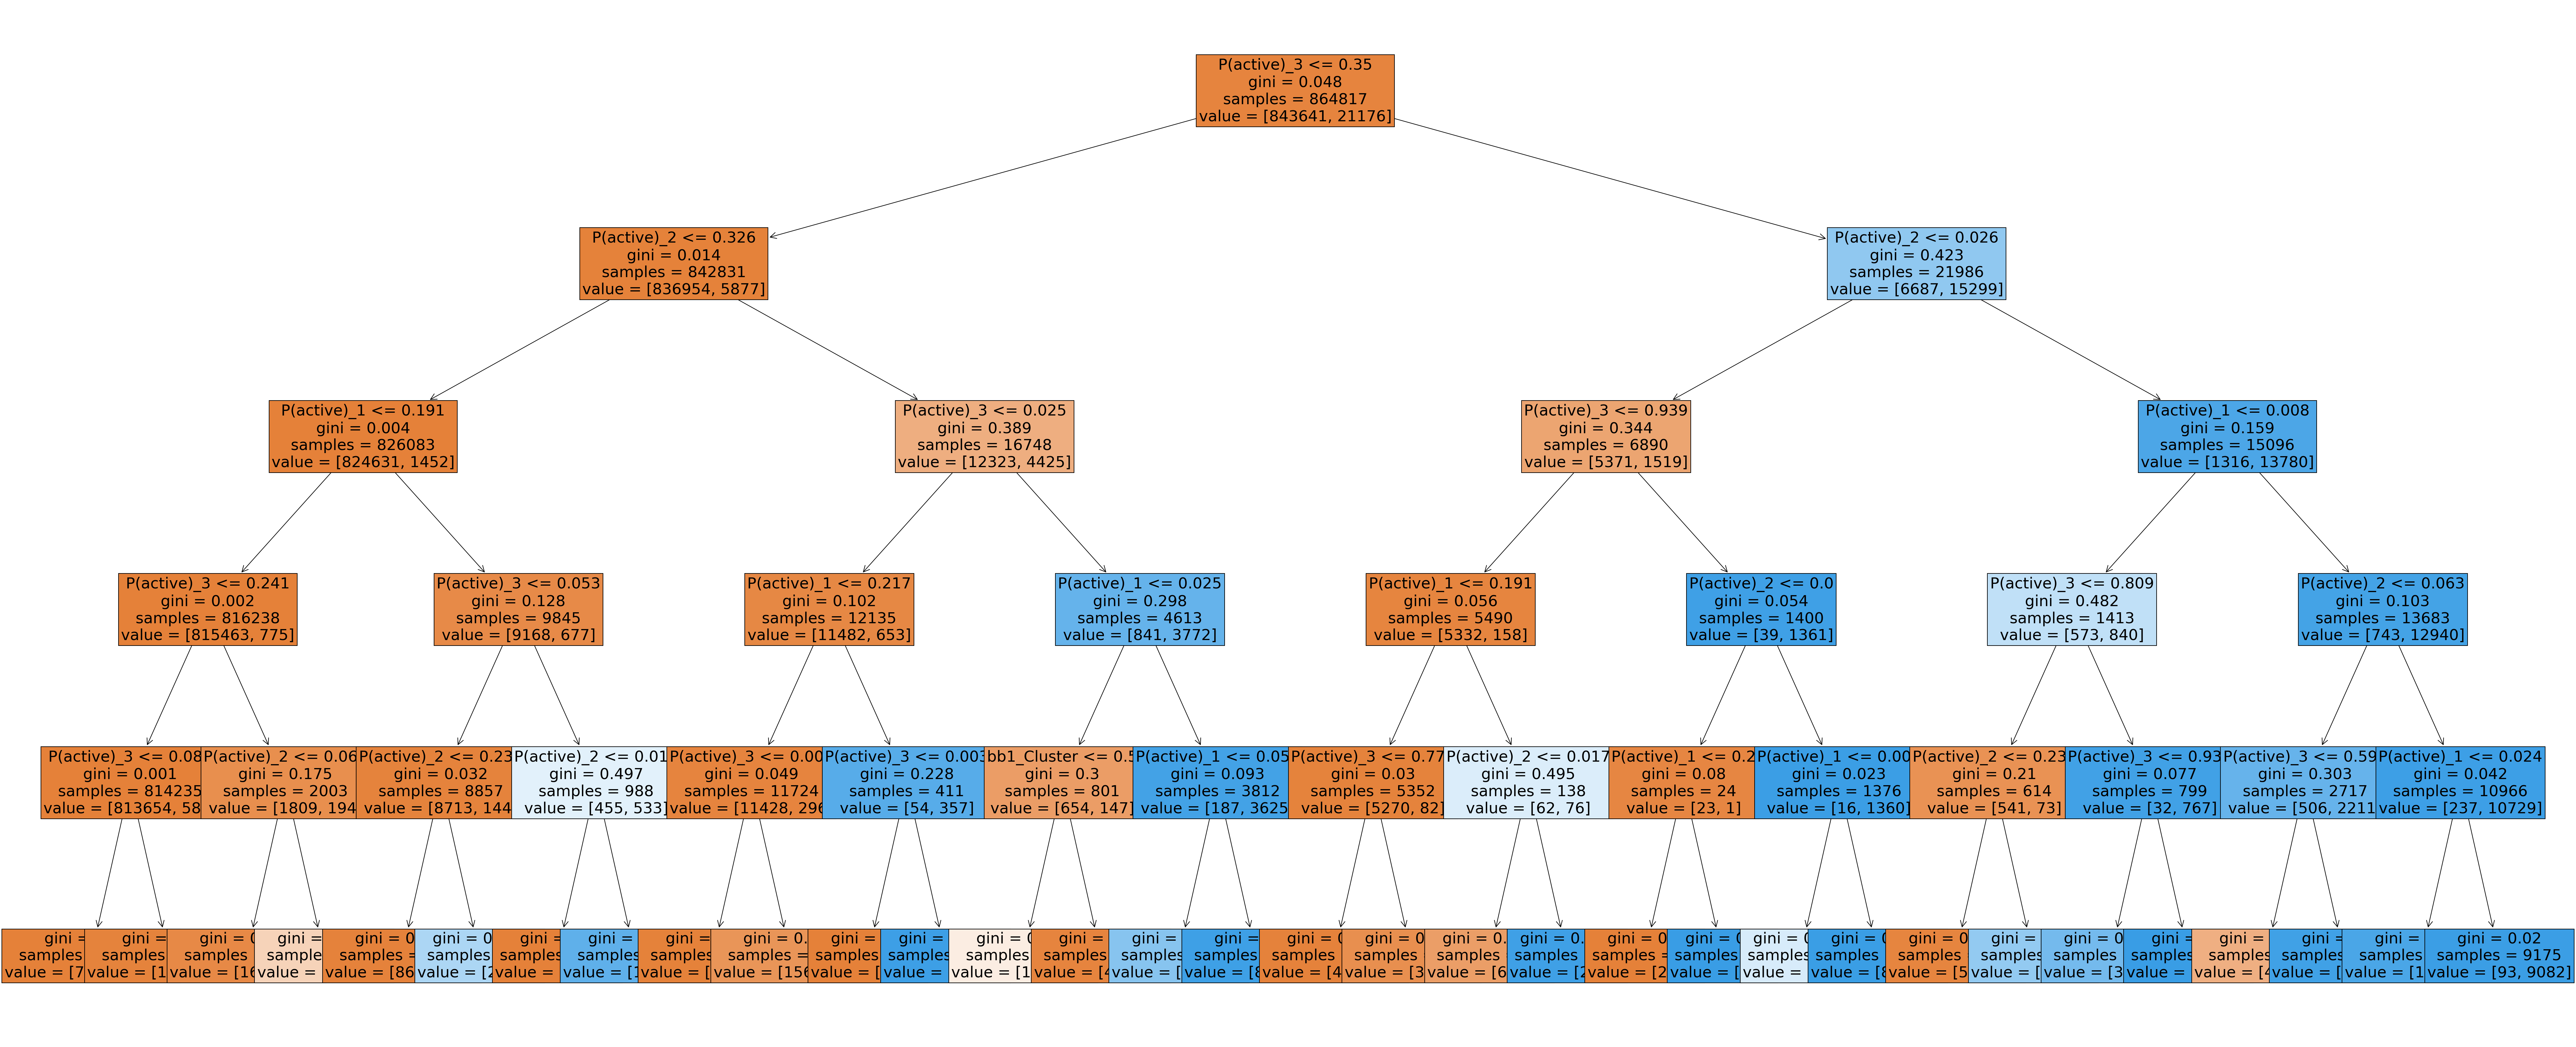

In [13]:
fig, axs = plt.subplots(figsize=(70, 30), dpi=150)
feature_names = ['bb1_Cluster', 'bb2_Cluster', 'bb3_Cluster',
                 'P(active)_1', 'P(active)_2', 'P(active)_3']
class_names = ['active', 'ina']
tree.plot_tree(tree_classifier, feature_names=feature_names, filled=True, ax=axs, fontsize=24)
plt.show()

### Evaluate decision tree performance

In [28]:
type(tree_classifier)

sklearn.tree._classes.DecisionTreeClassifier

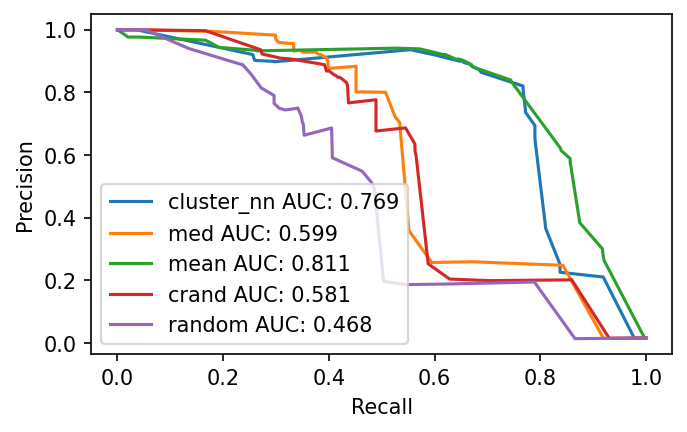

In [14]:
method = ['cluster_nn', 'med', 'mean', 'crand', 'random']
ans = pd.DataFrame(columns=method)
fig, axs = plt.subplots(dpi=150, figsize=(5,3))
for met in method:
    bb1_test[f'{met}'] = get_test_pred(bb1_test, 'bb1', bb1_ref, bb1_train, bb1_train_ind, bb1_dist, how=met, seed=seed_val)
    bb2_test[f'{met}'] = get_test_pred(bb2_test, 'bb2', bb2_ref, bb2_train, bb2_train_ind, bb2_dist, how=met, seed=seed_val)
    bb3_test[f'{met}'] = get_test_pred(bb3_test, 'bb3', bb3_ref, bb3_train, bb3_train_ind, bb3_dist, how=met, seed=seed_val)

    bb1_mod = bb1_test[['bb1', f'{met}', 'X', 'Y', 'Cluster']].rename(columns={f'{met}': 'P(active)'})
    bb2_mod = bb2_test[['bb2', f'{met}', 'X', 'Y', 'Cluster']].rename(columns={f'{met}': 'P(active)'})
    bb3_mod = bb3_test[['bb3', f'{met}', 'X', 'Y', 'Cluster']].rename(columns={f'{met}': 'P(active)'})

    bb1_comb = pd.concat([bb1_train, bb1_mod])
    bb2_comb = pd.concat([bb2_train, bb2_mod])
    bb3_comb = pd.concat([bb3_train, bb3_mod])

    test_input = format_data_for_tree(test, bb1_comb, bb2_comb, bb3_comb)
    test_prob = predict_activity(test_input, tree_classifier)
    val = calculate_auc(test_input['active'], test_prob)
    values.append(val)
    p,r,t = precision_recall_curve(test_input['active'], test_prob)
    
    test[f'{met}_prob'] = test_prob
    auc_values[f'{met}']['precision'] = p
    auc_values[f'{met}']['recall'] = r
    val = auc(r,p)
    axs.plot(r,p, label=f'{met} AUC: {val:.3f}')

axs.set_xlabel('Recall')
axs.set_ylabel('Precision')
axs.legend(loc='best')
plt.show()

### Export data

In [15]:
#pickle.dump(auc_values, open('auc_curve.pkl', 'wb'))
#test.to_csv('test_pred.csv', index=False)
#bb1_test.to_csv('bb1_pred.csv', index=False)
#bb2_test.to_csv('bb2_pred.csv', index=False)
#bb3_test.to_csv('bb3_pred.csv', index=False)